# Khóa học VIA - Phát hiện biển báo giao thông

<img width="120px" src="https://via.makerviet.org/media/via-logo.png">

**Website:** https://via.makerviet.org/

Nội dung khóa học này được tạo và phân phối miễn phí cho người học bởi các thành viên của dự án VIA. Toàn bộ bản quyền các nội dung trong khóa học thuộc về [MakerHanoi](https://www.facebook.com/makerhanoi/).


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makerhanoi/via-course-ai/blob/master/notebooks/05-Phat-hien-bien-bao.ipynb)


Ngoài việc đi đúng phần đường, làn đường của mình, các xe tự lái còn phải tuân thủ các hiệu lệnh giao thông như biển báo, đèn tín hiệu. Ở phần này, chúng ta sẽ ứng dụng các kĩ thuật xử lý ảnh và trí tuệ nhân tạo để phát hiện và phân loại các biển báo có trên đường và điều khiển xe theo chỉ dẫn của các biển báo đó. 

Luồng phát hiện và phân loại biển báo cơ bản sẽ gốm 3 bước chính:

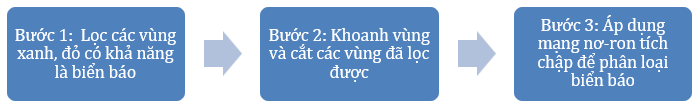

Ở bước thứ nhất, hình ảnh sẽ được đưa vào lọc màu để chọn ra toàn bộ các vùng có màu xanh hoặc màu đỏ, có thể là biển báo giao thông. Tiếp đó, các vùng này được cắt rời ra thành các vùng ảnh nhỏ tại bước 2 và đưa vào một mạng nơ-ron tích chập ở bước 3 để thực hiện phân loại.


Khai báo các thư viện cần thiết

In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## 1. Phát hiện biển báo thông qua màu sắc

Vì hệ màu HSV có khả năng phân biệt tốt các màu sắc, phù hợp với nhận thức của mắt người, để phát hiện các đối tượng biển báo thông qua màu sắc, ta đưa ảnh về hệ màu HSV và thực hiện lọc màu sắc theo các ngưỡng trong hệ màu đó.


### Tải dữ liệu thử nghiêm

Trước tiên cần tải về một số ảnh biển báo mẫu để thử nghiệm thuật toán:

In [2]:
# Chúng ta sẽ tải một số ảnh để tiện cho việc demo thuật toán cũng như làm mọi việc ở đây trở lên dễ hiểu hơn
!wget https://github.com/makerhanoi/via-course-ai/raw/master/content/images/traffic_sign_images.zip
!unzip traffic_sign_images.zip

--2021-12-01 18:01:17--  https://github.com/makerhanoi/via-course-ai/raw/master/content/images/traffic_sign_images.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/makerhanoi/via-course-ai/master/content/images/traffic_sign_images.zip [following]
--2021-12-01 18:01:17--  https://raw.githubusercontent.com/makerhanoi/via-course-ai/master/content/images/traffic_sign_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129341 (126K) [application/zip]
Saving to: ‘traffic_sign_images.zip’

traffic_sign_images 100%[===================>] 126.31K  --.-KB/s    in 0.02s   

2021-12-01 18:01:18 (6.

### Hiện ảnh

Hàm show_images() được chúng tôi viết sẵn để hiện ảnh trên notebook này, nó sẽ giúp chúng ta hiện nhiều ảnh cùng lúc trên file Notebook. Việc hiện ảnh trên các Notebook của Colab được thực hiện với hàm plt.imshow() từ thư viện matplotlib.

In [3]:
def show_images(images, cmap="viridis"):
    column = 3
    row = int(math.ceil(len(images)/column))
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(row,column,i+1)
        if cmap != "gray":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')

range(1, 7)


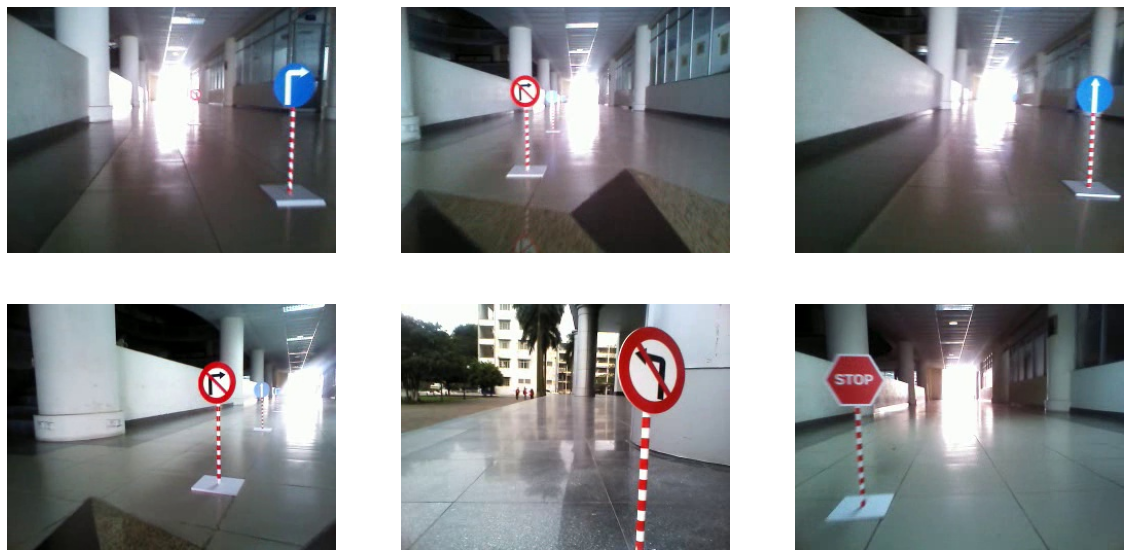

In [4]:
# Đọc hình ảnh
image_names = range(1,7)
print(image_names)
bgr_images = [cv2.imread(str(name) + ".jpg") for name in image_names]
show_images(bgr_images)

### Lọc theo màu sắc

Để chuyển đổi các ảnh trên sang hệ màu HSV, trước khi thực hiện lọc theo màu sắc, ta sử dụng hàm `cv2.cvtColor()` đã được làm quen trong bài học xử lý ảnh cơ bản.

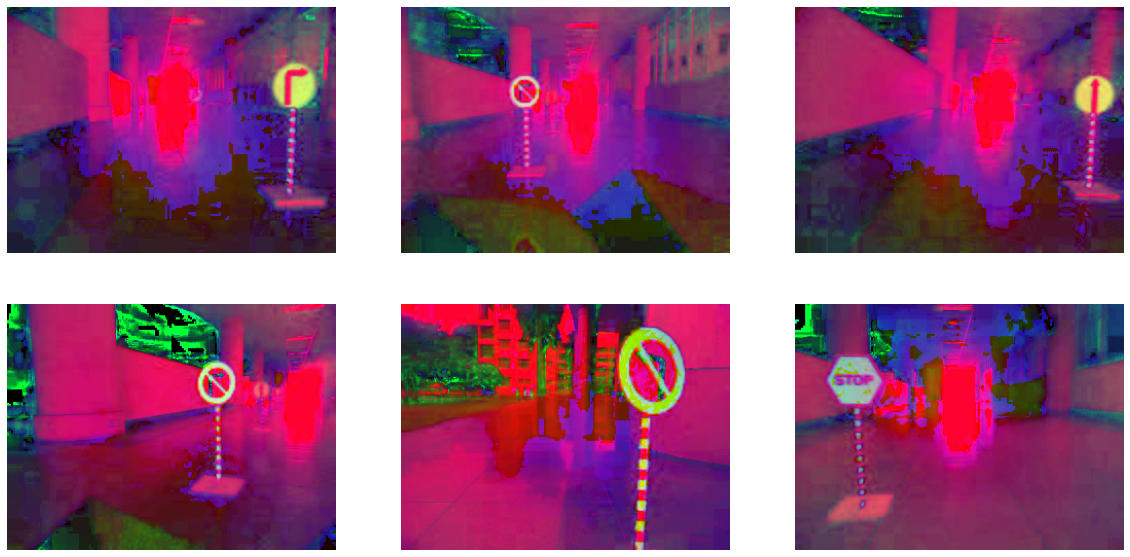

In [5]:
# mảng hsv sẽ lưu các ảnh đã được chuyển đổi sang hệ màu hsv
# sử dụng hàm cv2.cvtColor để convert ảnh từ dạng BGR sang HSV
hsvs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in bgr_images]
show_images(hsvs)

**Chọn ngưỡng màu thế nào?**

Sau khi chuyển ảnh sang hệ màu HSV, ta sẽ khảo sát và chọn ngưỡng màu để lọc ra các màu sắc cần thiết. Mỗi khoảng màu cần lọc sẽ bao gồm một ngưỡng dưới (lower) và một ngưỡng trên (upper).

Với các đối tượng có màu đỏ, ta lọc bằng 2 khoảng màu khác nhau:

```Python
lower1, upper1 = np.array([0,70,50]), np.array([10,255,255])
lower2, upper2 = np.array([170,70,50]), np.array([180,255,255])
```

Với các đối tượng có màu xanh dương:

```Python
lower3, upper3 = np.array([85,50,200]), np.array([135,250,250])
```

Thông qua hàm `filter_signs_by_color()` ta sẽ thu được một mặt nạ lọc, là một hình ảnh nhị phân có kích thước bằng kích thước ảnh ban đầu. Các điểm ảnh trong mặt nạ này sẽ có 2 giá trị là 0 (điểm ảnh tương ứng trong ảnh gốc không nằm trong khoảng màu cần lọc) và 255 (điểm ảnh tương ứng trong ảnh gốc nằm trong khoảng màu cần lọc).

In [6]:
def filter_signs_by_color(image):
    """Lọc các đối tượng màu đỏ và màu xanh dương - Có thể là biển báo.
        Ảnh đầu vào là ảnh màu BGR
    """
    # Chuyển ảnh sang hệ màu HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Lọc màu đỏ cho stop và biển báo cấm
    lower1, upper1 = np.array([0, 70, 50]), np.array([10, 255, 255])
    lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
    mask_1 = cv2.inRange(image, lower1, upper1) # dải màu đỏ thứ nhất
    mask_2 = cv2.inRange(image, lower2, upper2) # dải màu đỏ thứ hai
    mask_r = cv2.bitwise_or(mask_1, mask_2) # kết hợp 2 kết quả từ 2 dải màu khác nhau

    # Lọc màu xanh cho biển báo điều hướng
    lower3, upper3 = np.array([85, 50, 200]), np.array([135, 250, 250])
    mask_b = cv2.inRange(image, lower3,upper3)

    # Kết hợp các kết quả
    mask_final  = cv2.bitwise_or(mask_r,mask_b)
    return mask_final

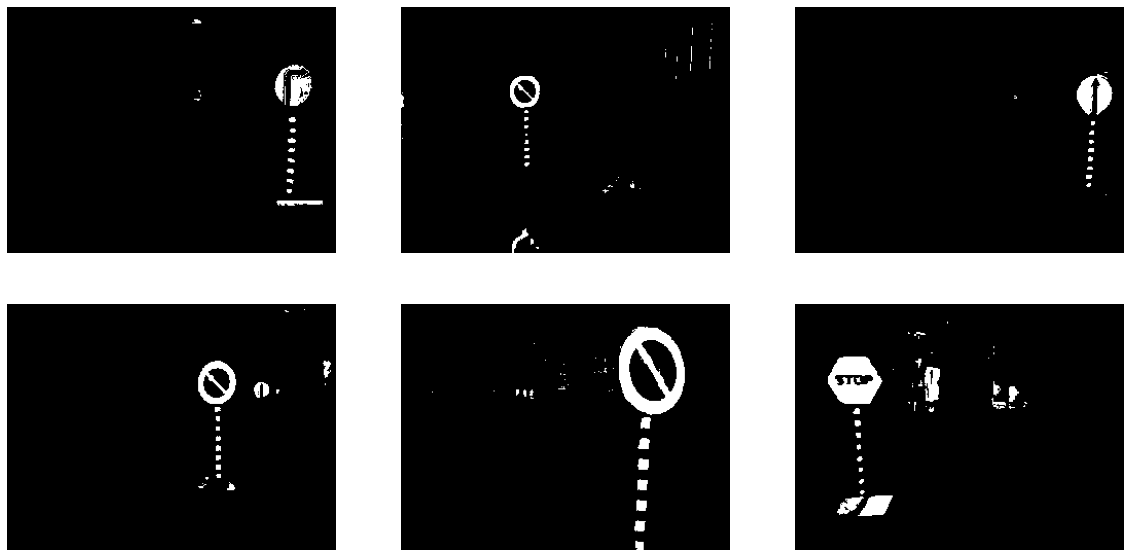

In [7]:
masks = [filter_signs_by_color(img) for img in bgr_images]
show_images(masks)

Sau khi lọc các biển báo theo màu sắc, ta có thể nhìn thấy các nhiễu là các vùng có màu giống biển báo, là cột biển, hoặc các vùng nền. Ở bước tiếp theo, ta cần đi lọc các nhiễu này và tìm ra vùng chữ nhật bao quanh biển báo, thường được gọi là `bounding box` của biển báo. 

In [8]:
def get_boxes_from_mask(mask):
    """Tìm kiếm hộp bao biển báo
    """
    bboxes = []

    nccomps = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    numLabels, labels, stats, centroids = nccomps
    im_height, im_width = mask.shape[:2]
    for i in range(numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        # Lọc các vật quá nhỏ, có thể là nhiễu
        if w < 20 or h < 20:
            continue
        # Lọc các vật quá lớn
        if w > 0.8 * im_width or h > 0.8 * im_height:
            continue
        # Loại bỏ các vật có tỷ lệ dài / rộng quá khác biệt
        if w / h > 2.0 or h / w > 2.0:
            continue
        bboxes.append([x, y, w, h])
    return bboxes


Ta tiến hành vẽ các kết quả lọc và tìm kiếm ở trên

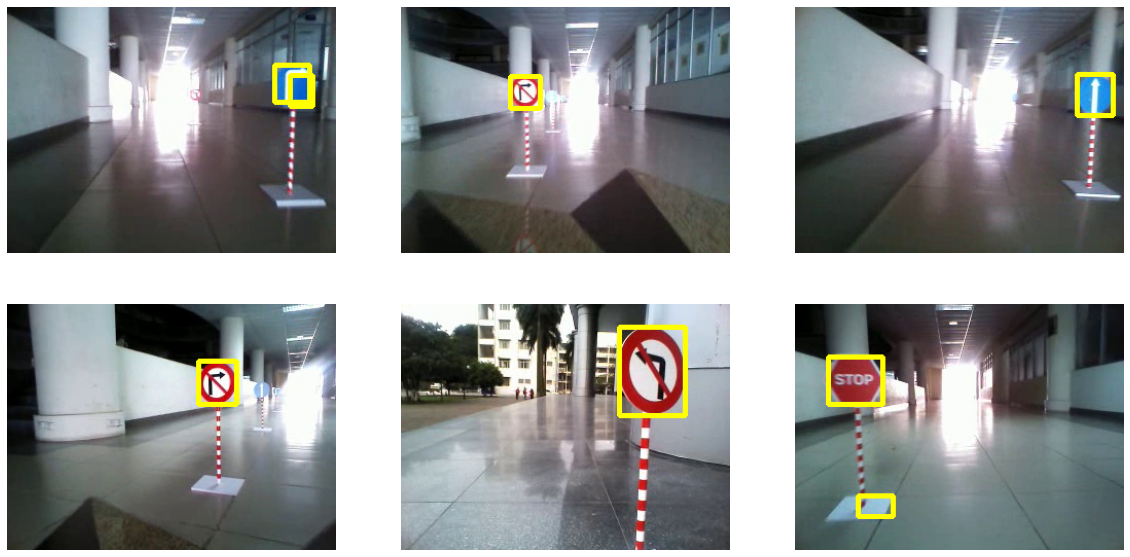

In [9]:
results = []
for i, img in enumerate(bgr_images):
    mask = filter_signs_by_color(img) # lọc theo màu sắc
    bboxes = get_boxes_from_mask(mask) # tìm kiếm khung bao của các vật từ mặt nạ màu sắc
    draw = img.copy() # Sao chép ảnh màu tương ứng để vẽ lên
    for bbox in bboxes:
        x, y, w, h = bbox
        # Vẽ khối hộp bao quanh biển báo
        cv2.rectangle(draw, (x,y), (x+w,y+h), (0,255,255), 4) # vẽ hình chữ nhật bao quanh vật
    results.append(draw)
show_images(results)

## 2. Phân loại biển báo với mạng nơ-ron tích chập

Sau khi lọc các biển báo theo màu sắc, việc tiếp theo chúng ta cần làm là phân loại chúng thành các biển báo khác nhau (biển dừng - stop, rẽ trái - left, rẽ phải - right, cấm rẽ trái - no_left, cấm rẽ phải - no_right, đi thẳng - straight). Các vật không phải biển báo cũng được nhận ra và phân loại thành đối tượng không xác định (unknown).

### Tìm hiểu về mạng nơ-ron tích chập (Convolutional neural network - CNN)

Mạng nơ-ron tích chập (Convolutional neural network - CNN) là một trong những mô hình học máy tiên tiến. Nó giúp cho chúng ta xây dựng được những hệ thống thông minh, thường dùng trong phân tích, nhận dạng hình ảnh với độ chính xác cao. Để tìm hiểu tại sao thuật toán này được sử dụng rộng rãi cho việc phân tích hình ảnh, chúng ta hãy cùng tìm hiểu về thuật toán này.

**Ma trận lọc học từ dữ liệu**

Trong bài học về các phép lọc ảnh, chúng ta đã được làm quen với các phép lọc sử dụng các bộ lọc tích chập. Chúng thực hiện nhân ma trận lọc với một cửa sổ trượt với toàn bộ ảnh. Các ma trận lọc khác nhau cho ta những ứng dụng khác nhau. Ví dụ với ma trận lọc trung bình, ma trận Gaussian ta có các bộ lọc giúp làm mịn ảnh. Với ma trận lọc Sobel, ta có bộ lọc giúp tìm các đường biên trong ảnh. Bằng việc thay đổi các trọng số trong các bộ lọc này, chúng ta trích xuất được các thông tin khác nhau từ hình ảnh đầu vào. Với việc kết hợp mạng nơ-ron nhân tạo vào phép nhân tích chập, chúng ta tạo ra các bộ lọc có khả năng "học" các trọng số này từ một lượng lớn dữ liệu. Các đặc trưng ngữ nghĩa được trích xuất bởi các bộ lọc này vượt xa các đặc trưng trích xuất bởi các bộ lọc được thiết kế bằng tay trong nhiều trường hợp, từ đó mở ra ứng dụng mới trong các bài toán thị giác máy.

![image](padding_strides.gif)

**Minh họa việc nhân ma trận ảnh. Hình ảnh được lấy từ <https://github.com/vdumoulin/conv_arithmetic>**

**Cấu trúc của mạng nơ-ron tích chập**

Một mạng nơ-ron tích chập là một tập hợp các lớp tích chập (convolution) chồng lên nhau, ở giữa có thêm các hàm kích hoạt phi tuyến như sigmoid, ReLU. Mỗi một lớp tích chập sẽ tạo ra các thông tin trừu tượng hơn cho các lớp tiếp theo. Thông tin khi đi vào các lớp về sau càng có tính tổng hợp cao, trích xuất được các ý nghĩa quan trọng của hình ảnh.

Trong quá trình huấn luyện một mạng nơ-ron tích chập, đưa hình ảnh đi qua toàn bộ mạng, sau đó cập nhật các trọng số (các tham số của các bộ lọc) dựa vào thuật toán lan truyền ngược - backpropagation. Các bạn có thể tham khảo về thuật toán này tại [Wikipedia](https://vi.wikipedia.org/wiki/Truy%E1%BB%81n_ng%C6%B0%E1%BB%A3c). Thật may mắn, quá trình lan truyền ngược và cập nhật trọng số đều đã được cài đặt trong các thư viện học máy, học sâu phổ biến như Tensorflow hay PyTorch, từ đó giúp chúng ta huấn luyện được các mạng nơ-ron tích chập dễ hàng hơn.

**Xây dựng mạng nơ-ron tích chập để phân loại biển báo**

Chúng ta có thể ứng dụng các thiết kế của mạng nơ-ron tích chập để xây dựng một mô hình phân loại biển báo. Đầu vào của mạng phân loại là hình ảnh, đi qua nhiều lớp tích chập để trích xuất các đặc trưng phục vụ phân loại. Ta ghép thêm vào đó các lớp kết nối fully connected và cuối cùng là đưa ra kết quả dự đoán cho các biển báo, trả lời câu hỏi: đối tượng vừa đưa vào thuộc loại biển báo nào?

Hình ảnh sau mô tả được kiến trúc mạng nơ-ron tích chập chúng ta sẽ xây dựng.

![](https://github.com/makerhanoi/via-course-ai/raw/master/content/images/cnn.png)

### Thử nghiệm với mô hình huấn luyện sẵn

Chúng tôi đã thực hiện huấn luyện sẵn một mô hình phân loại biển báo bằng kiến trúc mạng nơ-ron tích chập [LeNet](https://en.wikipedia.org/wiki/LeNet), xây dựng bởi nhà khoa học **Yann LeCun** năm 1989. Chúng ta sẽ tải về và thử nghiệm mô hình này trước khi tự xây dựng và huấn luyện một mô hình.

In [13]:
# Tải về mô hình huấn luyện sẵn
!wget https://github.com/makerhanoi/via-course-ai/raw/master/content/pretrained_models/traffic_sign_classifier_lenet_v2.onnx

--2021-12-01 18:04:10--  https://github.com/makerhanoi/via-course-ai/raw/master/content/pretrained_models/traffic_sign_classifier_lenet_v2.onnx
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/makerhanoi/via-course-ai/master/content/pretrained_models/traffic_sign_classifier_lenet_v2.onnx [following]
--2021-12-01 18:04:10--  https://raw.githubusercontent.com/makerhanoi/via-course-ai/master/content/pretrained_models/traffic_sign_classifier_lenet_v2.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458035 (447K) [application/octet-stream]
Saving to: ‘traffic_sign_classifier_lenet_v2.onnx’

traffi

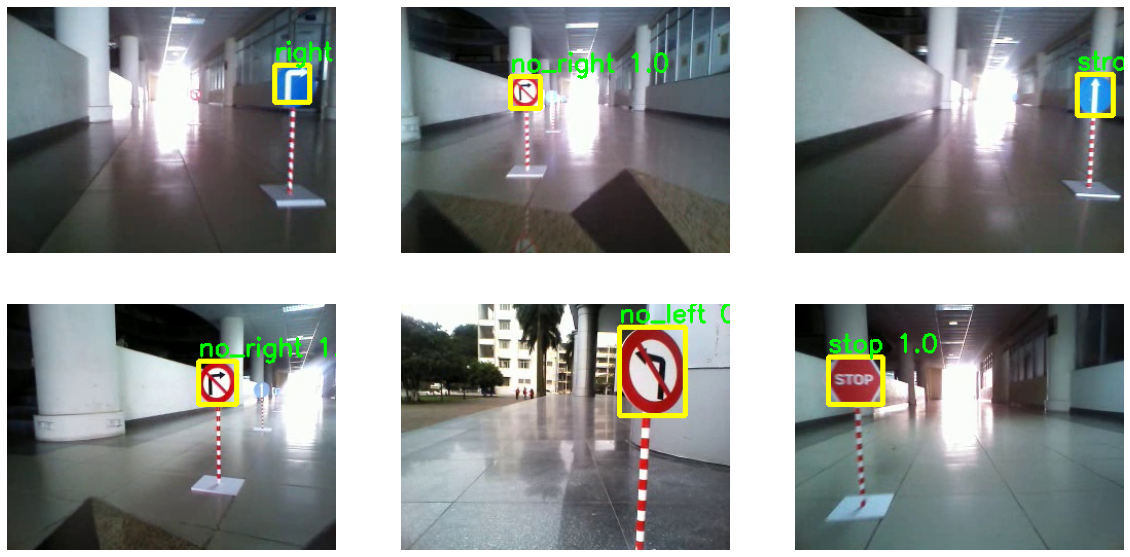

In [15]:
# Nạp mô hình bằng OpenCV
model = cv2.dnn.readNetFromONNX("traffic_sign_classifier_lenet_v2.onnx")

# Hàm phát hiện biển báo
def detect_traffic_signs(img, model, draw=None):
    """Phát hiện biển báo
    """

    # Các lớp biển báo
    classes = ['unknown', 'left', 'no_left', 'right',
               'no_right', 'straight', 'stop']

    # Phát hiện biển báo theo màu sắc
    mask = filter_signs_by_color(img)
    bboxes = get_boxes_from_mask(mask)

    # Tiền xử lý
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img / 255.0

    # Phân loại biển báo dùng CNN
    signs = []
    for bbox in bboxes:
        # Cắt vùng cần phân loại
        x, y, w, h = bbox
        sub_image = img[y:y+h, x:x+w]

        if sub_image.shape[0] < 20 or sub_image.shape[1] < 20:
            continue

        # Tiền xử lý
        sub_image = cv2.resize(sub_image, (32, 32))
        sub_image = np.expand_dims(sub_image, axis=0)

        # Sử dụng CNN để phân loại biển báo
        model.setInput(sub_image)
        preds = model.forward()
        preds = preds[0]
        cls = preds.argmax()
        score = preds[cls]

        # Loại bỏ các vật không phải biển báo - thuộc lớp unknown
        if cls == 0:
            continue

        # Loại bỏ các vật có độ tin cậy thấp
        if score < 0.9:
            continue

        signs.append([classes[cls], x, y, w, h])

        # Vẽ các kết quả
        if draw is not None:
            text = classes[cls] + ' ' + str(round(score, 2))
            cv2.rectangle(draw, (x, y), (x+w, y+h), (0, 255, 255), 4)
            cv2.putText(draw, text, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return signs

results = []
for i, img in enumerate(bgr_images):
    draw = img.copy()
    signs = detect_traffic_signs(img, model, draw=draw)
    results.append(draw)
show_images(results)
